# Final Capstone Project
## Best location for an Italian restaurant among top US cities

#### by Ignacio de Juan
#### January 2021, Final Project Assignment for IBM Data Science Course

### 1. Introduction / Business Problem

In this project we are going to undertake the mission of facilitating the decision making of where is the best location to open a new restaurant of a certain cuisine type in a top city of the USA. In this case it will be Italian cuisine.

The decision of opening a new restaurant should take into consideration the competition, demand and likelihood of success, taking into account as much information available.

Through this exercise we will address the following questions:

- Which are the cities with a highest potential based on the level of concentration of these type of restaurants?
- Is the size of the local Italian descent community a variable that affects the number of Italian restaurants? 
- What other factors should we take into account for such a decision? 

The result of our data science work will be a framework to help narrow down the initial 100 cities to a target of 10-15 cities where we see the highest potential of an Italian restaurant to succeed.

With the aid of Wikipedia tables and the Foursquare API we will navigate through the data, looking for insights and arguments to help our final decision.  

Lastly, we will point out the caveats and potential further developments of this exercise.

*Target Audience*

This analysis can be of interest to entrepreneurs, investors and corporates that are considering the set-up of a new business or the expansion of their current one. The provided framework can be useful to determine where to open the restaurant and what strategy should be followed.

### 2. Data

We will take data from top US cities, ranked by population. The reason for taking the largest cities is to achieve a sufficiently large dataset to draw valid conclusions. We will be using Wikipedia to identify the target cities of our study.

Foursquare will serve as our database for the restaurant data, retrieving the number of Italian restaurants and total restaurants, as well as the ratings for the Italian restaurants.

Additionally we are going to fetch from Wikipedia the statistics of how much of the population in each city comes from Italian descent. Since the information is not available at city level but only state level, we will take it as good enough for this exercise.

In the following sections we describe how is this information obtained and put in the right format to be used in the subsequent analysis phase.

### 3. Methodology

We will start by downloading the data, exploring it and plotting it to have a first approach of the problem. Then we will decide which models are more likely to help us to reach any conclusion and we will apply and test them.

#### 3.1. Set up

In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


%matplotlib inline
mpl.style.use(['seaborn'])

# !pip install python-dotenv

# Credentials file
%load_ext dotenv
%dotenv

import os

import json

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# display all rows and columns
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#### 3.2. Retrieving the Data 

##### 3.2.1. US cities data

We retrieve the list of US cities with their population and other relevant data

Source: Wikipedia, https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [2]:
# Code to retrieve the cities

url = 'https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population'
dfs = pd.read_html(url)

df = dfs[3]
df.head()

,2019rank,City,State[c],2019estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York City[d],New York,8336817,8175133,+1.98%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",".mw-parser-output .geo-default,.mw-parser-outp..."
1,2,Los Angeles,California,3979576,3792621,+4.93%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2693976,2695598,−0.06%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston[3],Texas,2320268,2100263,+10.48%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1680992,1445632,+16.28%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


Next, we will clean the city names to make them standard and usable in our queries to Foursquare API. 

In [3]:
df['City'] = df['City'].str.replace("\[.*\]","")
df['2016 population density.1'] = df['2016 population density.1'].str.replace("/km2","")
df['2016 population density.1'] = df['2016 population density.1'].str.replace(",","")
df.head()

,2019rank,City,State[c],2019estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York City,New York,8336817,8175133,+1.98%,301.5 sq mi,780.9 km2,"28,317/sq mi",10933,".mw-parser-output .geo-default,.mw-parser-outp..."
1,2,Los Angeles,California,3979576,3792621,+4.93%,468.7 sq mi,"1,213.9 km2","8,484/sq mi",3276,34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2693976,2695598,−0.06%,227.3 sq mi,588.7 km2,"11,900/sq mi",4600,41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston,Texas,2320268,2100263,+10.48%,637.5 sq mi,"1,651.1 km2","3,613/sq mi",1395,29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1680992,1445632,+16.28%,517.6 sq mi,"1,340.6 km2","3,120/sq mi",1200,33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


In [4]:
# We select the useful columns and reduce the number of cities to 100
df = df[["City","State[c]","2019estimate","2016 population density.1"]]
df = df.head(100)

In [5]:
df.rename(columns={"State[c]":"State","2019estimate":"Population","2016 population density.1":"Population density"},inplace = True)
df = df.assign(Population = round(df["Population"]/1000000,1))
df["Population density"] = df["Population density"].astype(int)
df.head()

,City,State,Population,Population density
0,New York City,New York,8.3,10933
1,Los Angeles,California,4.0,3276
2,Chicago,Illinois,2.7,4600
3,Houston,Texas,2.3,1395
4,Phoenix,Arizona,1.7,1200


In [6]:
# The scope of the analysis will be the top 100 cities ranked by population
cities = list(df['City'][0:100])
print(cities)

['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte', 'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington', 'Boston', 'El Paso', 'Nashville', 'Detroit', 'Oklahoma City', 'Portland', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore', 'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Mesa', 'Sacramento', 'Atlanta', 'Kansas City', 'Colorado Springs', 'Omaha', 'Raleigh', 'Miami', 'Long Beach', 'Virginia Beach', 'Oakland', 'Minneapolis', 'Tulsa', 'Tampa', 'Arlington', 'New Orleans', 'Wichita', 'Bakersfield', 'Cleveland', 'Aurora', 'Anaheim', 'Honolulu', 'Santa Ana', 'Riverside', 'Corpus Christi', 'Lexington', 'Henderson', 'Stockton', 'Saint Paul', 'Cincinnati', 'St. Louis', 'Pittsburgh', 'Greensboro', 'Lincoln', 'Anchorage', 'Plano', 'Orlando', 'Irvine', 'Newark', 'Durham', 'Chula Vista', 'Toledo', 'Fort Wayne', 'St. Petersburg', 'Laredo

##### 3.2.2. Venue data from Foursquare

In [7]:
# Foursquare API credentials and endpoint
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
VERSION = '20200616'
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)

We will now load the types of cuisines available in Foursquare.  
Source: https://developer.foursquare.com/docs/build-with-foursquare/categories

In [8]:
# We create a dicionary with the cuisines and the correspondent ID
cuisines = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f', 
    'Himalayan': '52e81612bcbc57f1066b79fb', 
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Tibetan': '52af39fb3cf9994f4e043be9', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Australian': '4bf58dd8d48988d169941735', 
    'Austrian': '52e81612bcbc57f1066b7a01', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Belgian': '52e81612bcbc57f1066b7a02', 
    'Caribbean': '4bf58dd8d48988d144941735', 
    'Caucasian': '5293a7d53cf9994f4e043a45', 
    'Czech': '52f2ae52bcbc57f1066b8b81', 
    'Dutch': '5744ccdfe4b0c0459246b4d0', 
    'Belarusian': '52e928d0bcbc57f1066b7e97', 
    'Bosnian': '58daa1558bbb0b01f18ec1ee', 
    'Bulgarian': '56aa371be4b08b9a8d5734f3', 
    'Romanian': '52960bac3cf9994f4e043ac4', 
    'Tatar': '52e928d0bcbc57f1066b7e98', 
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Greek': '4bf58dd8d48988d10e941735', 
    'Hawaiian': '52e81612bcbc57f1066b79fe', 
    'Hungarian': '52e81612bcbc57f1066b79fa', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735', 
    'Salvadoran': '5745c7ac498e5d0483112fdb', 
    'Argentinian': '4bf58dd8d48988d107941735', 
    'Brazilian': '4bf58dd8d48988d16b941735', 
    'Colombian': '58daa1558bbb0b01f18ec1f4', 
    'Peruvian': '4eb1bfa43b7b52c0e1adc2e8', 
    'Venezuelan': '56aa371be4b08b9a8d573558', 
    'Moroccan': '4bf58dd8d48988d1c3941735', 
    'Mexican': '4bf58dd8d48988d1c1941735', 
    'Egyptian': '5bae9231bedf3950379f89e1', 
    'Iraqi': '5bae9231bedf3950379f89e7', 
    'Israeli': '56aa371be4b08b9a8d573529', 
    'Kurdish': '5744ccdfe4b0c0459246b4ca', 
    'Lebanese': '58daa1558bbb0b01f18ec1cd', 
    'Persian': '52e81612bcbc57f1066b79f7', 
    'Syrian': '5bae9231bedf3950379f89da', 
    'Yemeni': '5bae9231bedf3950379f89ea', 
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Polish': '52e81612bcbc57f1066b7a04', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44', 
    'Scandinavian': '4bf58dd8d48988d1c6941735', 
    'Scottish': '5744ccdde4b0c0459246b4a3', 
    'Slovak': '56aa371be4b08b9a8d57355a', 
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Swiss': '4bf58dd8d48988d158941735', 
    'Turkish': '4f04af1f2fb6e1c99f3db0bb', 
    'Ukranian': '52e928d0bcbc57f1066b7e96'
}

We continue with the code to retrieve all the restaurants for each city and cuisine

In [9]:
# Important: In order to avoid loading the data from the Foursquare API every time the notebook is reloaded, we can download the data to a .csv file once and then reuse it. 

# Write DataFrame to CSV. Uncomment the first time you want to download the DataFrame to a CSV
#restaurants.to_csv('restaurants.csv', index=False)

read_local_file = True

if (read_local_file == True):
    restaurants_from_csv = pd.read_csv('restaurants.csv', keep_default_na=False, na_values=[""])
    restaurants = restaurants_from_csv
else:
    restaurants = pd.DataFrame(columns=['City', 'Cuisine', 'Total restaurants'])
    for city in cities:
        print(city)
        for cuisine_name, category_id in cuisines.items():
            # For each city, retrieve the top restaurants from Foursquare for each cuisine...
            query = requests.get("{url}&near={city}&categoryId={category_id}".format(url=URL, city=city, category_id=category_id))
            if query.status_code == 200:
                number = query.json()
                restaurants = restaurants.append({
                    'City': city,
                    'Cuisine': cuisine_name,
                    'Total restaurants': number['response']['totalResults']
                }, ignore_index=True)
        
restaurants.head()

,City,Cuisine,Total restaurants
0,New York City,Afghan,13
1,New York City,African,91
2,New York City,American,375
3,New York City,Burmese,9
4,New York City,Cambodian,9


In [10]:
# Let's see what cities have been properly downloaded
len(np.unique(restaurants['City']))

100

We will calculate the total restaurants per city, and the diversity of the cuisines for each one.

In [11]:
# Count the diversity of cuisines per city
restaurants['Diversity'] = restaurants['Total restaurants']>0 #If there exists at least one restaurant of certain cuisine, this will add 1 to diversity
restaurants.head(100)

restaurants[['City','Diversity']].groupby('City').sum().reset_index().sort_values(by = 'Diversity', ascending = False).head()


,City,Diversity
62,New York City,61.0
44,Jersey City,60.0
16,Chicago,57.0
83,San Francisco,54.0
51,Los Angeles,53.0


In [12]:
restaurants.head()

,City,Cuisine,Total restaurants,Diversity
0,New York City,Afghan,13,True
1,New York City,African,91,True
2,New York City,American,375,True
3,New York City,Burmese,9,True
4,New York City,Cambodian,9,True


In [13]:
restaurants_total = restaurants.groupby('City').sum().reset_index()
restaurants_total.head()

,City,Total restaurants,Diversity
0,Albuquerque,869,29.0
1,Anaheim,1451,48.0
2,Anchorage,413,26.0
3,Arlington,1114,46.0
4,Atlanta,1940,44.0


In [14]:
df_cities = pd.merge(restaurants_total, df, on='City')
df_cities['Diversity'].astype(int)
df_cities.sort_values('Population', ascending = False)

,City,Total restaurants,Diversity,State,Population,Population density
62,New York City,5493,61.0,New York,8.3,10933
51,Los Angeles,3929,53.0,California,4.0,3276
16,Chicago,3210,57.0,Illinois,2.7,4600
39,Houston,2959,48.0,Texas,2.3,1395
71,Phoenix,1612,45.0,Arizona,1.7,1200
...,...,...,...,...,...,...
9,Baton Rouge,531,25.0,Louisiana,0.2,1024
42,Irving,1256,46.0,Texas,0.2,1373
32,Garland,1448,44.0,Texas,0.2,1592
77,Richmond,905,34.0,Virginia,0.2,1441


Let's now calculate the amount of Italian restaurants for each city.

In [15]:
#italian_restaurants = restaurants[restaurants['Cuisine']=='Italian']
italian_restaurants = restaurants[restaurants['Cuisine']=='Italian'].copy()
italian_restaurants.drop(columns = ['Diversity'], inplace = True)
italian_restaurants.rename(columns = {'Total restaurants':'Italian restaurants'}, inplace = True)
italian_restaurants.head()
italian_restaurants

,City,Cuisine,Italian restaurants
36,New York City,Italian,334
100,Los Angeles,Italian,195
165,Chicago,Italian,214
230,Houston,Italian,164
295,Phoenix,Italian,130
...,...,...,...
6186,Milwaukee,Italian,68
6251,Albuquerque,Italian,45
6316,Tucson,Italian,91
6381,Fresno,Italian,35


In [16]:
df_cities = pd.merge(df_cities, italian_restaurants, on='City')
#df_cities = df_cities.join(italian_restaurants.set_index('City'), on='City', how='outer')
list(df_cities.columns)

['City',
 'Total restaurants',
 'Diversity',
 'State',
 'Population',
 'Population density',
 'Cuisine',
 'Italian restaurants']

In [17]:
df_cities = df_cities[["City","Total restaurants","Italian restaurants","Diversity","State","Population","Population density"]]
len(df_cities['City'].unique())
df_cities.sort_values(by = ['City'])
#df_cities.duplicated(subset=None, keep='first')
df_cities.shape

(99, 7)

Let's plot some of the information to find out about possible correlation patterns.

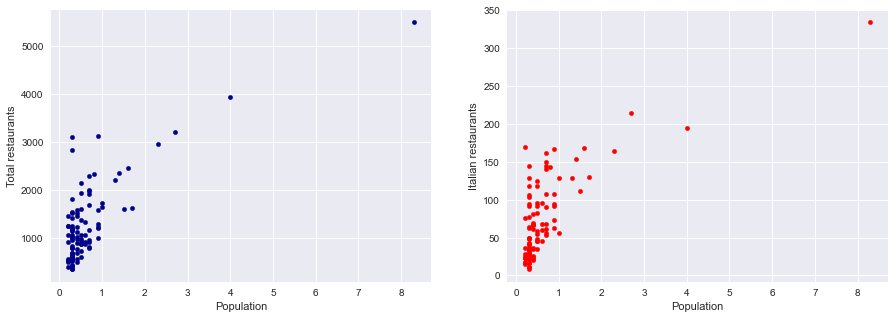

In [18]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)


ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue',figsize = (15,5), ax = ax1)

ax2 = df_cities.plot.scatter(x='Population',
                      y='Italian restaurants',
                      c='Red',figsize = (15,5), ax = ax2)

#### 3.2.3. Ratings for Italian cuisine restaurants in Foursquare

We will look at the ratings for the Italian restaurants in the selected cities, as an average of all the ratings available in the Foursquare API.

In [19]:
# List with ratings downloaded from Foursquare
# To learn how this info has been retrieved please consult
# the file Retrieve_ratings.ipynb located in this repo


ratings_avg_italian_restaurants = [['Albuquerque', 7.36],
 ['Anaheim', 8.27],
 ['Anchorage', 7.2],
 ['Arlington', 8.18],
 ['Atlanta', 8.41],
 ['Aurora', 8.6],
 ['Austin', 8.05],
 ['Bakersfield', 7.33],
 ['Baltimore', 8.26],
 ['Boston', 8.58],
 ['Buffalo', 8.09],
 ['Chandler', 8.77],
 ['Charlotte', 8.0],
 ['Chicago', 8.79],
 ['Chula Vista', 8.58],
 ['Cincinnati', 7.79],
 ['Cleveland', 8.04],
 ['Colorado Springs', 8.07],
 ['Columbus', 7.93],
 ['Corpus Christi', 7.54],
 ['Dallas', 8.09],
 ['Denver', 8.32],
 ['Detroit', 8.12],
 ['Durham', 7.82],
 ['El Paso', 7.89],
 ['Fort Wayne', 7.54],
 ['Fort Worth', 7.97],
 ['Fresno', 7.35],
 ['Gilbert', 8.61],
 ['Glendale', 8.77],
 ['Greensboro', 7.53],
 ['Henderson', 8.66],
 ['Honolulu', 7.03],
 ['Houston', 8.37],
 ['Indianapolis', 7.76],
 ['Irvine', 8.29],
 ['Jacksonville', 7.67],
 ['Jersey City', 9.24],
 ['Kansas City', 8.23],
 ['Laredo', 7.68],
 ['Las Vegas', 8.57],
 ['Lexington', 7.71],
 ['Lincoln', 7.55],
 ['Long Beach', 8.6],
 ['Los Angeles', 8.88],
 ['Louisville', 7.48],
 ['Lubbock', 7.59],
 ['Madison', 7.16],
 ['Memphis', 7.29],
 ['Mesa', 8.77],
 ['Miami', 8.83],
 ['Milwaukee', 7.99],
 ['Minneapolis', 8.48],
 ['Nashville', 8.01],
 ['New Orleans', 8.02],
 ['New York City', 9.19],
 ['Newark', 9.23],
 ['North Las Vegas', 8.69],
 ['Oakland', 8.89],
 ['Oklahoma City', 7.54],
 ['Omaha', 7.36],
 ['Orlando', 8.55],
 ['Philadelphia', 8.64],
 ['Phoenix', 8.79],
 ['Pittsburgh', 8.51],
 ['Plano', 8.67],
 ['Portland', 7.88],
 ['Raleigh', 7.8],
 ['Reno', 6.6],
 ['Riverside', 7.47],
 ['Sacramento', 7.69],
 ['Saint Paul', 8.27],
 ['San Antonio', 7.92],
 ['San Diego', 8.47],
 ['San Francisco', 8.75],
 ['San Jose', 7.69],
 ['Santa Ana', 8.41],
 ['Scottsdale', 8.75],
 ['Seattle', 8.28],
 ['St. Louis', 8.38],
 ['St. Petersburg', 8.05],
 ['Stockton', 6.98],
 ['Tampa', 8.35],
 ['Toledo', 7.89],
 ['Tucson', 6.98],
 ['Tulsa', 7.94],
 ['Virginia Beach', 7.48],
 ['Washington', 8.59],
 ['Wichita', 7.93],
 ['Baton Rouge', 7.95],
 ['Boise', 7.58],
 ['Chesapeake', 7.82],
 ['Fremont', 7.87],
 ['Garland', 8.5],
 ['Hialeah', 8.78],
 ['Irving', 8.65],
 ['Norfolk', 7.93],
 ['Richmond', 8.06],
 ['Spokane', 7.5],
 ['Winston-Salem', 7.83]]

# We convert the list to a DataFrame

df_ratings_avg_italian_restaurants = pd.DataFrame(ratings_avg_italian_restaurants, columns = ['City','Rating'])
df_ratings_avg_italian_restaurants.head()
df_ratings_avg_italian_restaurants

,City,Rating
0,Albuquerque,7.36
1,Anaheim,8.27
2,Anchorage,7.20
3,Arlington,8.18
4,Atlanta,8.41
...,...,...
95,Irving,8.65
96,Norfolk,7.93
97,Richmond,8.06
98,Spokane,7.50


In [20]:
# Now we can merge the contents with the master dataframe
df_cities = pd.merge(df_cities, df_ratings_avg_italian_restaurants, on='City')
#df_cities = df_cities.join(df_ratings_avg_italian_restaurants.set_index('City'), on='City', how='outer')
df_cities.head()
#df_cities.shape


,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27
2,Anchorage,413,22,26.0,Alaska,0.3,68,7.20
3,Arlington,1114,24,46.0,Texas,0.4,1600,8.18
4,Atlanta,1940,118,44.0,Georgia,0.5,1366,8.41


In [21]:
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27
2,Anchorage,413,22,26.0,Alaska,0.3,68,7.20
3,Arlington,1114,24,46.0,Texas,0.4,1600,8.18
4,Atlanta,1940,118,44.0,Georgia,0.5,1366,8.41
...,...,...,...,...,...,...,...,...
94,Tucson,938,91,35.0,Arizona,0.5,888,6.98
95,Tulsa,678,35,34.0,Oklahoma,0.4,791,7.94
96,Virginia Beach,775,61,34.0,Virginia,0.4,710,7.48
97,Washington,1989,140,50.0,District of Columbia,0.7,4304,8.59


#### 3.2.4. Population from Italian descent

Let's look at the percentage of population from Italian descent. 
Source: https://en.wikipedia.org/wiki/Italian_Americans#U.S._states_with_over_10%_people_of_Italian_ancestry

In [22]:
italian_origin = {'Alabama' : 1.7,
            'Alaska' : 3.3,
            'Arizona' : 4.4,
            'Arkansas' : 1.6,
            'California' : 4.0,
            'Colorado' : 5.1,
            'Connecticut' : 18.7,
            'Delaware': 9.9,
            'Florida' : 6.2,
            'Georgia' : 2.2,
            'Hawaii' : 2.1,
            'Idaho' : 3.2,
            'Illinois' : 6.2,
            'Indiana' : 2.7,
            'Iowa' : 2.1,
            'Kansas' : 2.3,
            'Kentucky' : 2.0,
            'Louisiana' : 4.8,
            'Maine' : 5.6,
            'Maryland' : 5.2,
            'Massachusetts' : 13.9,
            'Michigan' : 4.7,
            'Minnesota' : 2.3,
            'Mississippi' : 1.8,
            'Missouri' : 3.4,
            'Montana' : 3.5,
            'Nebraska' : 2.8,
            'Nevada' : 6.3,
            'New Hampshire' : 10.3,
            'New Jersey' : 16.8,
            'New Mexico' : 2.4,
            'New York' : 13.5,
            'North Carolina' : 3.0,
            'North Dakota' : 1.2,
            'Ohio' : 6.4,
            'Oklahoma' : 1.7,
            'Oregon' : 3.8,
            'Pennsylvania' : 12.2,
            'Rhode Island' : 18.9,
            'South Carolina' : 2.9,
            'South Dakota' : 1.4,
            'Tennessee' : 2.2,
            'Texas' : 1.9,
            'Utah' : 2.7,
            'Vermont' : 7.4,
            'Virginia' : 4.0,
            'Washington' : 3.6,
            'West Virginia' : 4.7,
            'Wisconsin' : 3.5,
            'Wyoming' : 3.1,
            'District of Columbia' : 3.3}


df_italian_origin = pd.DataFrame(list(italian_origin.items()),columns = ['State','Italian origin']) 
df_italian_origin.head()

,State,Italian origin
0,Alabama,1.7
1,Alaska,3.3
2,Arizona,4.4
3,Arkansas,1.6
4,California,4.0


In [23]:
df_cities = pd.merge(df_cities, df_italian_origin, on='State')
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating,Italian origin
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36,2.4
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27,4.0
2,Bakersfield,557,21,25.0,California,0.4,976,7.33,4.0
3,Chula Vista,1008,11,42.0,California,0.3,2080,8.58,4.0
4,Fremont,1253,169,44.0,California,0.2,1161,7.87,4.0
...,...,...,...,...,...,...,...,...,...
94,Portland,1981,108,52.0,Oregon,0.7,1851,7.88,3.8
95,Seattle,2334,143,51.0,Washington,0.8,3245,8.28,3.6
96,Spokane,401,23,30.0,Washington,0.2,1214,7.50,3.6
97,Washington,1989,140,50.0,District of Columbia,0.7,4304,8.59,3.3


### 3.3. Data Exploration 

#### 3.3.1. Description and Plotting

In [24]:
df_cities.describe()

,Total restaurants,Italian restaurants,Diversity,Population,Population density,Rating,Italian origin
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1282.989899,73.959596,40.686869,0.655556,1889.000000,8.090505,4.509091
std,831.166275,54.866242,8.925595,0.948922,1625.358761,0.550416,3.055577
min,342.000000,8.000000,16.000000,0.200000,68.000000,6.600000,1.700000
25%,748.500000,32.500000,34.000000,0.300000,951.500000,7.690000,2.550000
50%,1059.000000,61.000000,42.000000,0.400000,1373.000000,8.050000,4.000000
75%,1582.000000,104.500000,46.500000,0.700000,2016.500000,8.575000,5.100000
max,5493.000000,334.000000,61.000000,8.300000,10933.000000,9.240000,16.800000


In [25]:
df_cities.corr()

,Total restaurants,Italian restaurants,Diversity,Population,Population density,Rating,Italian origin
Total restaurants,1.000000,0.832166,0.779608,0.755017,0.756973,0.599019,0.431319
Italian restaurants,0.832166,1.000000,0.648958,0.722920,0.541868,0.430444,0.372089
Diversity,0.779608,0.648958,1.000000,0.405916,0.610265,0.692311,0.391502
Population,0.755017,0.722920,0.405916,1.000000,0.562141,0.289715,0.230124
Population density,0.756973,0.541868,0.610265,0.562141,1.000000,0.551468,0.587415
Rating,0.599019,0.430444,0.692311,0.289715,0.551468,1.000000,0.428859
Italian origin,0.431319,0.372089,0.391502,0.230124,0.587415,0.428859,1.000000


In the above correlation table we can see that the number of restaurants is correlated with population and the number of Italian restaurants less so. The larger the city, more variety of food, what results into less weighting of Italian restaurants.

We can add some calculations between columns to help us reach conclusions:
- Percentage of Italian restaurants among the Total
- Total restaurants per thousand inhabitants
- Total Italian restaurants per thousand inhabitants
- Amount of restaurants of other cuisines 

In [26]:

df_cities['italian_rest_perc'] = round(df_cities['Italian restaurants']/df_cities['Total restaurants']*100,1)
df_cities
df_cities['italian_rest_per_m_pop']=round(df_cities['Italian restaurants']/(df_cities['Population']*1000),2)
df_cities['total_rest_per_m_pop']=round(df_cities['Total restaurants']/(df_cities['Population']*1000),2)
df_cities['Other restaurants'] = df_cities['Total restaurants'] - df_cities['Italian restaurants']


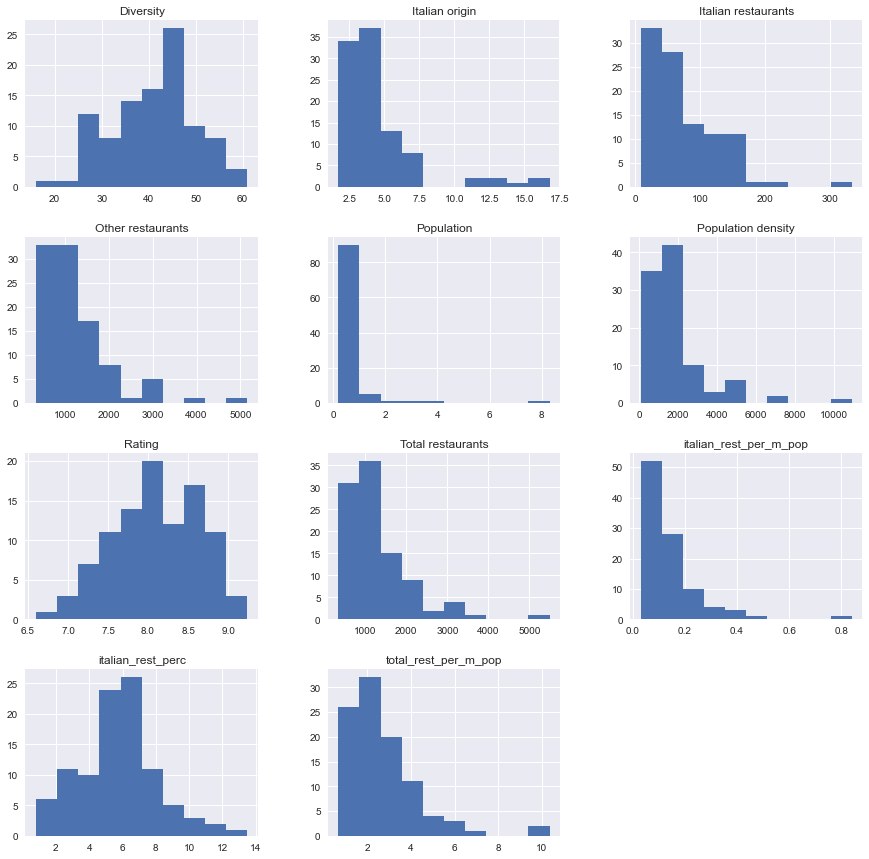

In [27]:
hist = df_cities.hist(figsize = (15,15))

In [28]:
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36,2.4,5.2,0.08,1.45,824
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27,4.0,1.5,0.06,3.63,1429
2,Bakersfield,557,21,25.0,California,0.4,976,7.33,4.0,3.8,0.05,1.39,536
3,Chula Vista,1008,11,42.0,California,0.3,2080,8.58,4.0,1.1,0.04,3.36,997
4,Fremont,1253,169,44.0,California,0.2,1161,7.87,4.0,13.5,0.84,6.26,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Portland,1981,108,52.0,Oregon,0.7,1851,7.88,3.8,5.5,0.15,2.83,1873
95,Seattle,2334,143,51.0,Washington,0.8,3245,8.28,3.6,6.1,0.18,2.92,2191
96,Spokane,401,23,30.0,Washington,0.2,1214,7.50,3.6,5.7,0.12,2.00,378
97,Washington,1989,140,50.0,District of Columbia,0.7,4304,8.59,3.3,7.0,0.20,2.84,1849


Before we end the data gathering, in order to make the data more consistant we will remove the following rows:
- the two largest cities, New York and Los Angeles, since they are outliers in terms of population size.
- Jersey City, since it is an outlier in number of restaurants per thousand inhabitants.

In [29]:
df_cities.drop([8,41,76],inplace = True)
df_cities.reset_index(drop=True)

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36,2.4,5.2,0.08,1.45,824
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27,4.0,1.5,0.06,3.63,1429
2,Bakersfield,557,21,25.0,California,0.4,976,7.33,4.0,3.8,0.05,1.39,536
3,Chula Vista,1008,11,42.0,California,0.3,2080,8.58,4.0,1.1,0.04,3.36,997
4,Fremont,1253,169,44.0,California,0.2,1161,7.87,4.0,13.5,0.84,6.26,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Portland,1981,108,52.0,Oregon,0.7,1851,7.88,3.8,5.5,0.15,2.83,1873
92,Seattle,2334,143,51.0,Washington,0.8,3245,8.28,3.6,6.1,0.18,2.92,2191
93,Spokane,401,23,30.0,Washington,0.2,1214,7.50,3.6,5.7,0.12,2.00,378
94,Washington,1989,140,50.0,District of Columbia,0.7,4304,8.59,3.3,7.0,0.20,2.84,1849


And we redo the histogram

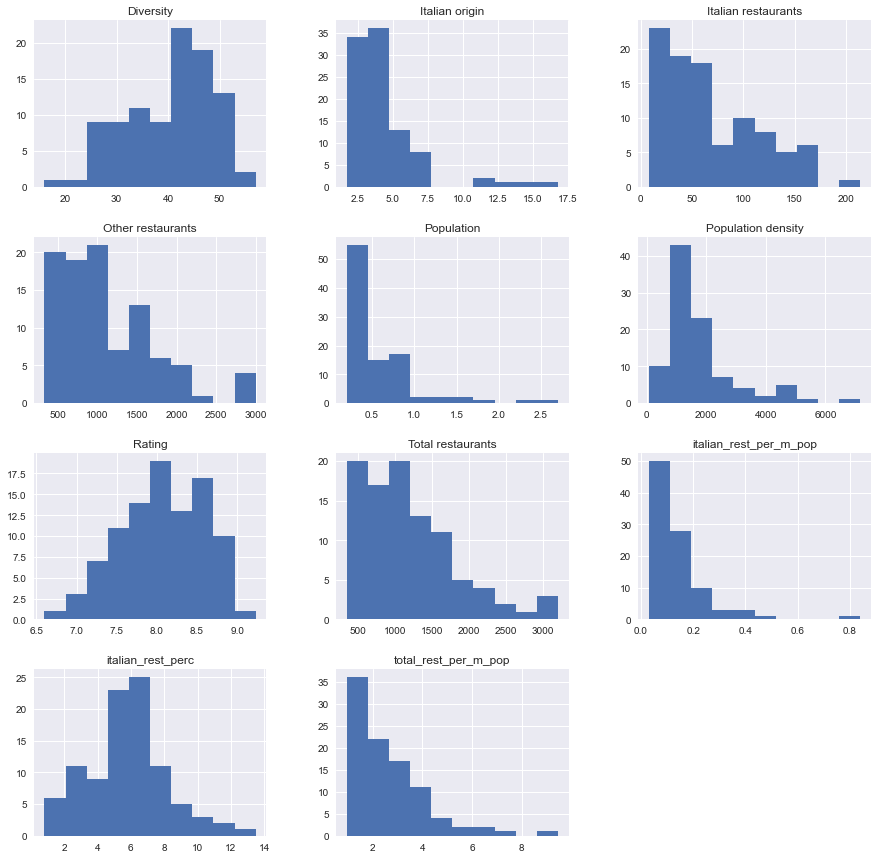

In [30]:
hist = df_cities.hist(figsize = (15,15))

In [31]:
df_cities.head()
df_cities.dtypes

City                       object
Total restaurants           int64
Italian restaurants         int64
Diversity                 float64
State                      object
Population                float64
Population density          int64
Rating                    float64
Italian origin            float64
italian_rest_perc         float64
italian_rest_per_m_pop    float64
total_rest_per_m_pop      float64
Other restaurants           int64
dtype: object

In [32]:
df_cities

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36,2.4,5.2,0.08,1.45,824
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27,4.0,1.5,0.06,3.63,1429
2,Bakersfield,557,21,25.0,California,0.4,976,7.33,4.0,3.8,0.05,1.39,536
3,Chula Vista,1008,11,42.0,California,0.3,2080,8.58,4.0,1.1,0.04,3.36,997
4,Fremont,1253,169,44.0,California,0.2,1161,7.87,4.0,13.5,0.84,6.26,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Portland,1981,108,52.0,Oregon,0.7,1851,7.88,3.8,5.5,0.15,2.83,1873
95,Seattle,2334,143,51.0,Washington,0.8,3245,8.28,3.6,6.1,0.18,2.92,2191
96,Spokane,401,23,30.0,Washington,0.2,1214,7.50,3.6,5.7,0.12,2.00,378
97,Washington,1989,140,50.0,District of Columbia,0.7,4304,8.59,3.3,7.0,0.20,2.84,1849


In [33]:
df_cities.corr()

,Total restaurants,Italian restaurants,Diversity,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
Total restaurants,1.000000,0.773041,0.792712,0.655730,0.633006,0.554257,0.286755,-0.003569,0.173822,0.312740,0.998781
Italian restaurants,0.773041,1.000000,0.620851,0.661603,0.357262,0.357613,0.281034,0.592013,0.491037,0.029904,0.740781
Diversity,0.792712,0.620851,1.000000,0.411290,0.558980,0.652243,0.288445,0.016832,0.244632,0.383678,0.791118
Population,0.655730,0.661603,0.411290,1.000000,0.222682,0.180200,0.003980,0.170601,-0.213543,-0.395907,0.642891
Population density,0.633006,0.357262,0.558980,0.222682,1.000000,0.497254,0.443832,-0.200060,0.057760,0.343516,0.642513
Rating,0.554257,0.357613,0.652243,0.180200,0.497254,1.000000,0.346585,-0.114573,0.194729,0.458647,0.559095
Italian origin,0.286755,0.281034,0.288445,0.003980,0.443832,0.346585,1.000000,0.159948,0.288719,0.328920,0.281786
italian_rest_perc,-0.003569,0.592013,0.016832,0.170601,-0.200060,-0.114573,0.159948,1.000000,0.610572,-0.235005,-0.049852
italian_rest_per_m_pop,0.173822,0.491037,0.244632,-0.213543,0.057760,0.194729,0.288719,0.610572,1.000000,0.520988,0.145852
total_rest_per_m_pop,0.312740,0.029904,0.383678,-0.395907,0.343516,0.458647,0.328920,-0.235005,0.520988,1.000000,0.328847


We are going to calculate the p coefficients to see the statistical significance of each variable.

In [34]:
from scipy.stats import pearsonr
df_cities.corr(method=lambda x, y: round(pearsonr(x, y)[1],6))

,Total restaurants,Italian restaurants,Diversity,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
Total restaurants,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004618,0.972468,0.090321,0.001920,0.000000
Italian restaurants,0.000000,1.000000,0.000000,0.000000,0.000353,0.000348,0.005544,0.000000,0.000000,0.772411,0.000000
Diversity,0.000000,0.000000,1.000000,0.000031,0.000000,0.000000,0.004372,0.870699,0.016301,0.000114,0.000000
Population,0.000000,0.000000,0.000031,1.000000,0.029205,0.078939,0.969301,0.096543,0.036704,0.000065,0.000000
Population density,0.000000,0.000353,0.000000,0.029205,1.000000,0.000000,0.000006,0.050664,0.576171,0.000611,0.000000
Rating,0.000000,0.000348,0.000000,0.078939,0.000000,1.000000,0.000542,0.266334,0.057276,0.000003,0.000000
Italian origin,0.004618,0.005544,0.004372,0.969301,0.000006,0.000542,1.000000,0.119548,0.004333,0.001068,0.005413
italian_rest_perc,0.972468,0.000000,0.870699,0.096543,0.050664,0.266334,0.119548,1.000000,0.000000,0.021179,0.629554
italian_rest_per_m_pop,0.090321,0.000000,0.016301,0.036704,0.576171,0.057276,0.004333,0.000000,1.000000,0.000000,0.156211
total_rest_per_m_pop,0.001920,0.772411,0.000114,0.000065,0.000611,0.000003,0.001068,0.021179,0.000000,1.000000,0.001071


Let's highlight the interesting correlations of the number of Italian restaurants and the other variables, always bearing in mind that correlation means assotiation, not causation:

**Irrelevant correlations (r < 0.3)**
- Italian origin is correlated at 0.28 both with Italian restaurants as well as with Other restaurants. So this is clearly not a driver of Italian restaurants.

**Weak correlations** (0.3 < r < 0.5):
- Population density (0.36)
- Rating (0.36)


**Moderate correlation** (0.5 < r < 0.7):
- Diversity (0.64)
- Population (0.66)

**Strong correlation** ( r > 0.7):
- Other restaurants (0.74)

Let's plot it


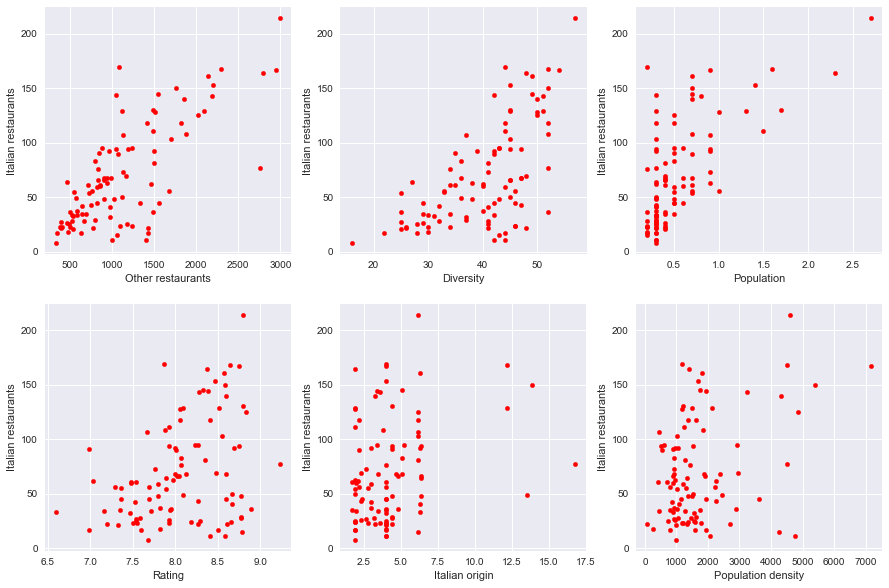

In [35]:
fig = plt.figure()

# Divide the figure into a 2x3 grid, and give me the first section
ax1 = fig.add_subplot(231)

ax2 = fig.add_subplot(232)

ax3 = fig.add_subplot(233)

ax4 = fig.add_subplot(234)

ax5 = fig.add_subplot(235)

ax6 = fig.add_subplot(236)

ax1 = df_cities.plot.scatter(x='Other restaurants',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax1)

ax2 = df_cities.plot.scatter(x='Diversity',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax2)

ax3 = df_cities.plot.scatter(x='Population',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax3)

ax4 = df_cities.plot.scatter(x='Rating',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax4)

ax5 = df_cities.plot.scatter(x='Italian origin',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax5)

ax6 = df_cities.plot.scatter(x='Population density',
                      y='Italian restaurants',
                      c='Red',figsize = (15,10), ax = ax6)

From the scattered plots we deduct that Population and Other restaurants are the two features that have a higher correlation that seems to be linear. Diversity also has quite consistency and Rating and Italian origin do have less of a linear correlation.

The histograms show that in general the distributions are highly concentrated among the left side of the charts, which probably derives from the fact that most of the cities are concentrated below 1M inhabitants. The closest we see to a normal distribution can be found in the rating histogram as well as the italian_rest_perc histogram.

In [36]:
df_cities[['City','italian_rest_perc','Italian origin','Population','State']].sort_values(by = 'State')

,City,italian_rest_perc,Italian origin,Population,State
17,Anchorage,5.3,3.3,0.3,Alaska
46,Phoenix,8.1,4.4,1.7,Arizona
47,Scottsdale,8.3,4.4,0.3,Arizona
48,Tucson,9.7,4.4,0.5,Arizona
44,Glendale,3.5,4.4,0.3,Arizona
...,...,...,...,...,...
54,Norfolk,4.4,4.0,0.2,Virginia
95,Seattle,6.1,3.6,0.8,Washington
96,Spokane,5.7,3.6,0.2,Washington
84,Madison,5.6,3.5,0.3,Wisconsin


In [37]:
df_states = df_cities[['City','State']].groupby('State').count().sort_values(by = 'City', ascending = False)

In [38]:
df_states['Perc'] = round(df_states['City']/df_states['City'].sum(),2)
df_states.head()

,City,Perc
State,,
California,15,0.16
Texas,13,0.14
Arizona,7,0.07
Florida,6,0.06
Virginia,4,0.04


In [39]:
df_cities.head()

,City,Total restaurants,Italian restaurants,Diversity,State,Population,Population density,Rating,Italian origin,italian_rest_perc,italian_rest_per_m_pop,total_rest_per_m_pop,Other restaurants
0,Albuquerque,869,45,29.0,New Mexico,0.6,1147,7.36,2.4,5.2,0.08,1.45,824
1,Anaheim,1451,22,48.0,California,0.4,2711,8.27,4.0,1.5,0.06,3.63,1429
2,Bakersfield,557,21,25.0,California,0.4,976,7.33,4.0,3.8,0.05,1.39,536
3,Chula Vista,1008,11,42.0,California,0.3,2080,8.58,4.0,1.1,0.04,3.36,997
4,Fremont,1253,169,44.0,California,0.2,1161,7.87,4.0,13.5,0.84,6.26,1084


**Level of market saturation**

One useful calculation that we are going to make is the level of market saturation vs the percentage of Italian restaurants. This will give us an indication of the markets with potential growth.

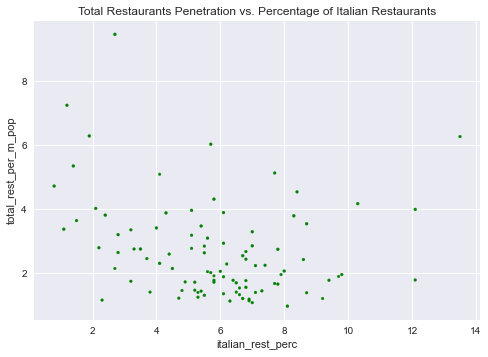

In [40]:
df_cities['bubble_rating'] = df_cities['Rating']
ax6 = plt.scatter(x='italian_rest_perc',
                      y='total_rest_per_m_pop',s = 'bubble_rating',
                      c='Green', data=df_cities)
plt.xlabel("italian_rest_perc")
plt.ylabel("total_rest_per_m_pop")
plt.title("Total Restaurants Penetration vs. Percentage of Italian Restaurants")
plt.show()

The above chart shows on the Y axis the amount of restaurants per thousand inhabitants, and the X axis the percentage of Italian restaurants. 
The attractive market is where the Y axis is low, with low level of saturation of restaurants, and the X axis low as well, so there are less Italian restaurants and this means there is room for more.  
Besides, we are going to rank the target space by ratings, so we can identify the cities where the ratings are lower, so it is going to be easier to face competition when we land with our new Italian restaurants.  
We will start with the cities with less than 4 restaurants per 1000 inhabitants, and less or equal than 4% of Italian restaurants among those restaurants.

In [41]:
#df.loc[(df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
df_target = df_cities.loc[(df_cities['total_rest_per_m_pop'] < 4)  & (df_cities['italian_rest_perc'] <= 4),['City','State','Italian restaurants','total_rest_per_m_pop','italian_rest_perc','Rating']].sort_values(by = 'Rating')

df_target



,City,State,Italian restaurants,total_rest_per_m_pop,italian_rest_perc,Rating
16,Stockton,California,17,2.13,2.7,6.98
2,Bakersfield,California,21,1.39,3.8,7.33
10,Riverside,California,32,3.34,3.2,7.47
27,Laredo,Texas,8,1.14,2.3,7.68
11,Sacramento,California,45,2.74,3.3,7.69
14,San Jose,California,56,1.73,3.2,7.69
53,Chesapeake,Virginia,18,2.44,3.7,7.82
18,Arlington,Texas,24,2.78,2.2,8.18
1,Anaheim,California,22,3.63,1.5,8.27
3,Chula Vista,California,11,3.36,1.1,8.58


In [42]:
# Extract the index list for further calculations
target_index_list = df_target.index.to_list()
print(target_index_list)

[16, 2, 10, 27, 11, 14, 53, 18, 1, 3, 7, 43, 65, 44, 9]


In [43]:
df_target_states = df_target[['City','State']].groupby('State').count()
df_target_states
df_target_states['Perc'] = round(df_target_states['City']/df_target_states['City'].sum(),2)
df_target_states

,City,Perc
State,,
Arizona,2,0.13
California,9,0.60
Nevada,1,0.07
Texas,2,0.13
Virginia,1,0.07


We have a first list of 15 locations that seem attractive because there is still a low penetration of restaurants, and the percentage of Italian restaurants is also low. So we are looking for a good market opportunity in terms of size as well as differentiation opportunities versus the competition.  

Next we are going to go one step further and model the data. We would like to make a prediction of how many restaurants should there be in those locations if they were following the "general rule" of the the other cities. This will help us to confirm if there is a market opportunity, and rank the target cities by the largest gap of existing Italian restaurants vs. potential predicted Italian restaurants.

#### 3.3.2. Modeling
##### 3.3.2.1. Multiple Linear Regression

Since we have infered from the charts that the main relations with the data are linear, let's explore the Multiple Linear Regression model.

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Selecting the features for regression
cols = ['Other restaurants','Italian restaurants','Diversity','Population','Population density','Rating','Italian origin']
df_cities_r = df_cities[cols].copy()

# with all variables
#cols_x = ['Other restaurants', 'Diversity','Population','Population density','Rating','Italian origin']

# eliminating multicolinear variables
#cols_x = ['Other restaurants','Population','Rating','Italian origin']
cols_x = ['Other restaurants','Population','Population density','Diversity','Rating']
#cols_x = ['Other restaurants']


# Scaling the dataset
# X = np.asanyarray(df_cities_r[cols_x])
X = df_cities_r[cols_x]
scaler_x = MinMaxScaler().fit(X)


# y = np.asanyarray(df_cities_r[['Italian restaurants']])
y = df_cities_r[['Italian restaurants']]
scaler_y = MinMaxScaler().fit(y)


#df_cities_r[cols] = min_max_scaler.fit_transform(df_cities_r[cols])




df_cities_r.head()


,Other restaurants,Italian restaurants,Diversity,Population,Population density,Rating,Italian origin
0,824,45,29.0,0.6,1147,7.36,2.4
1,1429,22,48.0,0.4,2711,8.27,4.0
2,536,21,25.0,0.4,976,7.33,4.0
3,997,11,42.0,0.3,2080,8.58,4.0
4,1084,169,44.0,0.2,1161,7.87,4.0


In [45]:
# Creating train and test dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [46]:
# Multiple Regression Model

from sklearn import linear_model
from sklearn import metrics
regr = linear_model.LinearRegression()
X_train_s = scaler_x.transform(np.asanyarray(X_train))
y_train_s = scaler_y.transform(np.asanyarray(y_train))
regr.fit (X_train_s, y_train_s)
# The coefficients
print ('Coefficients: ', regr.coef_)
# Coefficients:  [[0.45693203 0.06279319 0.4804892  0.06439731 0.02770891]]

Coefficients:  [[ 0.67998606  0.26996591 -0.24316333  0.20738622 -0.08421355]]


In [47]:
# Prediction
X_test_s = scaler_x.transform(np.asanyarray(X_test))
y_test_s = scaler_y.transform(np.asanyarray(y_test))
y_hat_s = regr.predict(X_test_s)

print("Residual sum of squares: %.2f"% np.mean((y_hat_s - y_test_s) ** 2))

# R2
accuracy_lr = metrics.r2_score(y_test_s, y_hat_s)
print('R-square:',accuracy_lr)


Residual sum of squares: 0.02
R-square: 0.3202748658091539


Let's run cross validation:

In [48]:
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

scores = cross_val_score(linear_model.LinearRegression(),scaler_x.transform(X),scaler_y.transform(y), cv = 3)
#cross_val_score(linear_model.RandomForestClassifier(),X,y, cv = 3)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.524 (0.143)


And use the model for predictions:

Text(0, 0.5, 'Predictions')

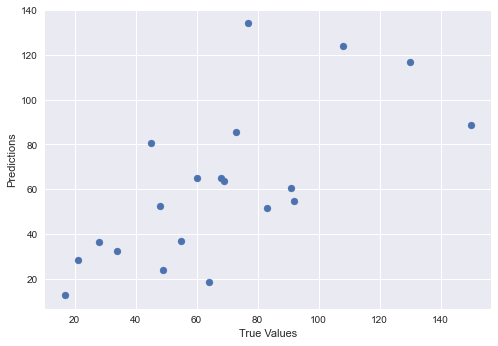

In [49]:
predicted_number_italian_rest_test = scaler_y.inverse_transform(regr.predict(scaler_x.transform(X_test)))
#y_test_values = np.asanyarray(test[['Italian restaurants']])
plt.scatter(y_test, predicted_number_italian_rest_test)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [50]:
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 0.67998606  0.26996591 -0.24316333  0.20738622 -0.08421355]]


We can depict the importance of each one of the features:

Feature: 0, Score: 0.67999 Other restaurants
Feature: 1, Score: 0.26997 Population
Feature: 2, Score: -0.24316 Population density
Feature: 3, Score: 0.20739 Diversity
Feature: 4, Score: -0.08421 Rating


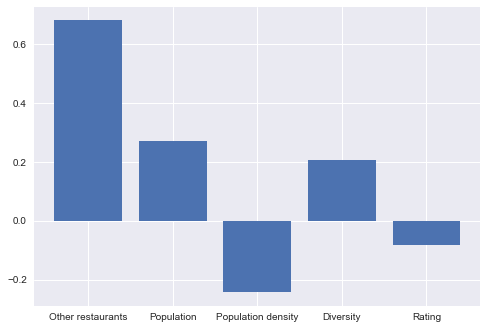

In [51]:
# get importance
importance = regr.coef_[0]
features = cols_x
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v), features[i])
# plot feature importance
plt.bar(features, importance)
plt.show()

We can see that the amount of Other restaurants is the main driver to the number of Italian restaurants, followed by Population, Diversity and Population density. Rating is the feature of least importance, and it is negative, which means that the more Italian restaurants, the lower the ratings for them.

##### 3.3.2.2. Polynomial Regression  

The relationship has shown to be clearly linear, but as a means of enriching this exercise  further, let's test the polynomial regression model and see if it shows a better regression than the Multiple Linear Regression.

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Training the model

train_x = scaler_x.transform(np.asanyarray(X_train))
train_y = scaler_y.transform(np.asanyarray(y_train))

test_x = scaler_x.transform(np.asanyarray(X_test))
test_y = scaler_y.transform(np.asanyarray(y_test))

poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

# Experimento
X_s = scaler_x.transform(np.asanyarray(X))
x_poly = poly.fit_transform(X_s)

# Fitting the model

clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)


# Evaluation

from sklearn.metrics import r2_score

test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Coefficients:  [[ 0.          0.4089469  -0.55411973  0.01109488  0.61970023 -0.03125758
   0.13033262 -0.77325169  1.10927129  1.21410839 -1.21254912 -0.48562896
   0.91949548 -1.8021495   4.01901279 -0.08589669 -4.49978276  3.18348026
   0.20339427  0.3538487  -0.87606253]]
Intercept:  [-0.02369365]
Mean absolute error: 0.14
Residual sum of squares (MSE): 0.03
R2-score: 0.23


In [53]:
scores = cross_val_score(linear_model.LinearRegression(),x_poly,y, cv = 3)


print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.155 (0.322)


The polynomial regression has a R2 of 0.23, and when going through cross validation the accuracy is only 0.155, therefore we discard it because this model does not explain the dependencies of our target variable.  
Next, we are going to use our prediction model to see how many restaurants should exist in each of the cities. Let's take for example Stockton.

###### 3.3.2.3. Using Predictions with Multiple Linear Model

We are going to take the list of Target cities that we selected by the fact that they have low number of total restaurants and low percentage of Italian restaurants, and we are going to use the regression model to see what would be the potential number of restaurants in those cities, and rank them by that number.

In [54]:
# We calculate the predicted number of restaurants using the Linear
# Regression model.
predicted_number_italian_rest = scaler_y.inverse_transform(regr.predict(scaler_x.transform(np.asanyarray(X)[target_index_list])))
#print(predicted_number_italian_rest)


# print(len(predicted_number_italian_rest))
# df_target.shape

df_target['predicted_rest'] = predicted_number_italian_rest.astype(int)
# df_target['predicted_rest'] = df_target['predicted_rest'].astype(int)
df_target.head()
#print(scaler_x.inverse_transform(x[[14]]))
#scaler_y.inverse_transform(regr.predict(x[[14]]))
df_target['predicted_gap'] = df_target['predicted_rest']-df_target['Italian restaurants']
df_target.sort_values(by = ['predicted_gap'], ascending = False)

,City,State,Italian restaurants,total_rest_per_m_pop,italian_rest_perc,Rating,predicted_rest,predicted_gap
11,Sacramento,California,45,2.74,3.3,7.69,146,101
18,Arlington,Texas,24,2.78,2.2,8.18,113,89
44,Glendale,Arizona,29,2.74,3.5,8.77,116,87
1,Anaheim,California,22,3.63,1.5,8.27,81,59
10,Riverside,California,32,3.34,3.2,7.47,80,48
3,Chula Vista,California,11,3.36,1.1,8.58,52,41
43,Gilbert,Arizona,22,2.63,2.8,8.61,62,40
7,Long Beach,California,45,3.19,2.8,8.60,79,34
53,Chesapeake,Virginia,18,2.44,3.7,7.82,40,22
9,Oakland,California,36,3.80,2.4,8.89,56,20


### 4. Results

We have been able to gather all the information we needed from Foursquare and Wikipedia, and the data has shown to be quite consistent.  

Looking at the ratios of amount of restaurants relative to population size, compared with the percentage of Italian restaurants, it looks as if there are some interesting cities to invest at first sight. Moreover, if we look at the ratings for Italian restaurants, we can have a hint that the competition may be weaker (it could also be that the population in different cities have different expectations).  

Adding to the previous analysis, we have prepared a model to be capable of ranking the opportunities based on the gap between the "normal" amount of restaurants expected and the number in reality. Although the model has not shown to have a large R-square, it is nevertheless useful to rank opportunities.

### 5. Discussion

With the aid of data engineering and statistical analysis we have created a framework that could serve as a basis of discussion with our investor. We have seen that despite the similarities in size, American cities show large variations of the amount of restaurants relative to its population. Most of the cities that have fulfilled our conditions to be targeted are in California (60% belong to this state, being 15% in the intial list), which could be a good thing so the investments can all be done on one area, but it could also show that California has other factors that make it not attractive. This is something that goes beyond the scope of this analysis.

### 6. Conclusions



#### Further research and caveats of this analysis

##### Caveats
- Foursquare data may be uneven in different cities even if we have chosen all cities in US  
- Ethnic origin of population is at state level, not city level
- The population in the Wikipedia table may refer to a different geography than the geography applied by Foursquare in the queries

##### Further research
- Look at the evolution in time  
- Analyse the preferences of the consumers also in terms of assessment of the existing restaurants  
- Differentiate different level of budget in the restaurants  
- Look at composition of the population and income in the city
- Zoom into the cities that have been selected to better understand the competition, both in geographical terms as well as other types of cuisines. We should make an analysis of the neighbourhoods to identify the best locations for our restaurants.
- Polinomial regression analysis: number or IT rest (y), number of rest, pop size, italian origin, average punctuation feedback